In [ ]:
import sys

sys.path.append("../")


In [ ]:
from datetime import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from CurveBuilder import calc_ust_metrics
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_mles_ols,
)
from CurvyCUSIPs.utils.viz import plot_usts, run_basic_linear_regression_df, plot_residuals_timeseries

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"]) 


In [ ]:
quote_type = "eod"
as_of_date = datetime(2024, 10, 3)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df


cusip security_type auction_date issue_date maturity_date  \
0    912797LS4          Bill   2024-09-05 2024-09-10    2024-10-08   
1    912797LT2          Bill   2024-09-12 2024-09-17    2024-10-15   
2    912797LU9          Bill   2024-09-19 2024-09-24    2024-10-22   
3    912797LV7          Bill   2024-09-26 2024-10-01    2024-10-29   
4    912797MA2          Bill   2024-09-05 2024-09-10    2024-11-05   
..         ...           ...          ...        ...           ...   
390  912810TT5          Bond   2023-10-12 2023-10-16    2053-08-15   
391  912810TV0          Bond   2024-01-11 2024-01-16    2053-11-15   
392  912810TX6          Bond   2024-04-11 2024-04-15    2054-02-15   
393  912810UA4          Bond   2024-07-11 2024-07-15    2054-05-15   
394  912810UC0          Bond   2024-09-12 2024-09-16    2054-08-15   

     time_to_maturity  int_rate  high_investment_rate is_on_the_run  \
0            0.013699       NaN                 5.171         False   
1            0.032877       NaN                 5.053         False   
2            0.052055       NaN                 4.783         False   
3            0.071233       NaN                 4.783          True   
4            0.090411       NaN                 5.150         False   
..                ...       ...                   ...           ...   
390         28.884932     4.125                   NaN         False   
391         29.136986     4.750                   NaN         False   
392         29.389041     4.250                   NaN         False   
393         29.632877     4.625                   NaN         False   
394         29.884932     4.250                   NaN          True   

         ust_label  ...      parValue percentOutstanding  est_outstanding_amt  \
0    5.171% Oct-24  ...  7.725101e+08           0.003348         2.307550e+11   
1    5.053% Oct-24  ...  7.980483e+08           0.003458         2.307652e+11   
2    4.783% Oct-24  ...  7.665970e+08           0.003322         2.307462e+11   
3    4.783% Oct-24  ...  6.932014e+08           0.003005         2.306985e+11   
4    5.150% Nov-24  ...  4.049427e+08           0.002884         1.403951e+11   
..             ...  ...           ...                ...                  ...   
390  4.125% Aug-53  ...  8.606596e+09           0.120247         7.157430e+10   
391  4.750% Nov-53  ...  4.567153e+08           0.006874         6.644364e+10   
392  4.250% Feb-54  ...  2.211754e+09           0.031064         7.119879e+10   
393  4.625% May-54  ...  7.428279e+09           0.097202         7.642080e+10   
394  4.250% Aug-54  ...  4.964611e+09           0.095538         5.196489e+10   

     corpus_cusip outstanding_amt  portion_unstripped_amt  \
0             NaN    0.000000e+00                     NaN   
1             NaN    0.000000e+00                     NaN   
2             NaN    0.000000e+00                     NaN   
3             NaN    0.000000e+00                     NaN   
4             NaN    0.000000e+00                     NaN   
..            ...             ...                     ...   
390     912803GU1    7.157430e+10              60387609.0   
391     912803GW7    6.644364e+10              56016095.5   
392     912803GY3    7.119879e+10              56926048.7   
393     912803HB2    7.642080e+10              67351522.8   
394     912803HD8    5.196489e+10              48018361.6   

     portion_stripped_amt  reconstituted_amt  free_float  rank  
0            0.000000e+00                NaN   -772.5101  16.0  
1            0.000000e+00                NaN   -798.0483  15.0  
2            0.000000e+00                NaN   -766.5970  14.0  
3            0.000000e+00                NaN   -693.2014  13.0  
4            0.000000e+00                NaN   -404.9427  12.0  
..                    ...                ...         ...   ...  
390          1.118669e+10           460890.0  51781.0128   4.0  
391          1.042755e+10           298806.8  55559.3802   3.0  
392          1.427274e+1

In [ ]:
otr_df = curve_set_df[curve_set_df["is_on_the_run"]].sort_values(by=["time_to_maturity"])
otr_fit_interpolator = GeneralCurveInterpolator(
    x=otr_df["time_to_maturity"].to_numpy(),
    y=otr_df[f"{quote_type}_yield"].to_numpy(),
)


In [ ]:
# remove otr, olds, double olds, triple olds
curve_set_filtered_df = curve_set_df[
    (curve_set_df["rank"] != 0)
    & (curve_set_df["rank"] != 1)
    & (curve_set_df["rank"] != 2)
    & (curve_set_df["rank"] != 3)
]

# remove TBills
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]

# remove low free float bonds (< $5bn)
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]

# filter out bonds very close to maturity
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]

# remove CTDs
curve_set_filtered_df = curve_set_filtered_df[
    ~curve_set_filtered_df["cusip"].isin(
        [
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"], # TU
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"], # Z3N
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"], # FV
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"], # TY
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"], # TN
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"], # US
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"], # TWE
            curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"], # UL
        ]
    )
]

curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)


In [ ]:
ns_func, status_ns = calibrate_ns_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_ns

nss_func, status_nss, _ = calibrate_nss_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
assert status_nss

mles_func, status_mles = calibrate_mles_ols(
    curve_set_filtered_df["time_to_maturity"].to_numpy(),
    curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=9,
)


In [ ]:
fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)
fitted_unispline = filtered_fitted_interpolator.univariate_spline(s=1.75, return_func=True)

plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[("3.125% Nov-41", "red"), ("2.000% Nov-41", "blue")],
    zero_curves=[
        # (
        #     otr_fit_interpolator.pchip_interpolation(return_func=True),
        #     "PCHIP Intrp - OTR Fit",
        # ),
        (
            fitted_bspline,
            "BSpline k=3 - Zero Filtered Fit",
        ),
        (
            mles_func,
            "Zero, mles"
        ),
    ],
    par_curves=[
        (
            fitted_bspline,
            "BSpline k=3 - Par FF",
        ),
        # (
        #     fitted_unispline,
        #     "Unispline s=1.75 - Par FF",
        # ),
        # (
        #     mles_func,
        #     "Par, MLES",
        #     True
        # ),
    ],
    # n_yr_fwd_curves=[
    #     (
    #         nss_func,
    #         1,
    #         "1yr Fwd, NSS",
    #     ) 
    # ]
    impl_spot_n_yr_fwd_curves=[
        (fitted_bspline, 1, "Impl Spots, 1y Fwd"),
    ],
    impl_par_n_yr_fwd_curves=[
        (fitted_bspline, 1, "Impl Par, 1y Fwd"),
        # (
        #     mles_func,
        #     1,
        #     "1yr Fwd, MLES",
        #     True
        # )
    ],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}"
)


c:\Users\chris\Curvy-CUSIPs\notebooks\..\models\MLESM.py:47: RuntimeWarning:

divide by zero encountered in divide



In [ ]:
label = "3.125% Nov-41"
bond_info = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(ust_label=label)
curr_price = curve_set_df[curve_set_df["ust_label"] == label][f"{quote_type}_price"].values[0]
curr_ytm = curve_set_df[curve_set_df["ust_label"] == label][f"{quote_type}_yield"].values[0]

calc_ust_metrics(bond_info=bond_info, curr_price=curr_price, curr_ytm=curr_ytm, as_of_date=as_of_date, scipy_interp=fitted_bspline)


{'zspread': 30.91019256811117,
 'zspread_impl_clean_price': 87.63759016066496,
 'clean_price': 87.63318544994245,
 'dirty_price': 91.18951518816564,
 'accrued_amount': 0.0,
 'bps': -0.11226509468377885,
 'dv01_1mm': -1122.6509468377885,
 'mac_duration': 13.07614901359789,
 'mod_duration': 12.81089733437715,
 'convexity': 200.72409356244418,
 'basis_point_value': -0.11226509468377885,
 'yield_value_basis_point': -8.907418362772657e-06,
 '3m_fwd_yield': 4.823598640995064,
 '3m_carry_and_roll': 4.299160385505112,
 '6m_fwd_yield': 4.629982230638818,
 '6m_carry_and_roll': 5.291514803075922,
 '9m_fwd_yield': 4.436654816375096,
 '9m_carry_and_roll': 4.672687143230472,
 '12m_fwd_yield': 4.308186041836581,
 '12m_carry_and_roll': 5.578783552399982}

In [ ]:
nov_41s_df = curve_data_fetcher.fetch_spreads(
    ust_label_spread="3.125% Nov-41 / 2.000% Nov-41",
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 9, 26),
)


In [ ]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0)
        & (curve_set_df["rank"] != 1)
        & (curve_set_df["rank"] != 2)
        & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["security_type"] != "Bill"
    ]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["free_float"] > 5000
    ]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[
        curve_set_filtered_df["time_to_maturity"] > 30 / 360
    ]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"], # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"], # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"], # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"], # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"], # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"], # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"], # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"], # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])
    
    return curve_set_filtered_df


In [ ]:
start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 10, 1)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[("LPF", "eod_yield", liquidity_premium_curve_set_filter)],
)


AGGREGATING CURVE SET DFs: 100%|██████████| 190/190 [00:05<00:00, 37.37it/s]


In [ ]:
cusip_spreads = {}

for dt in curve_sets_dict_df.keys():
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
        k=3,
        return_func=True,
    )
    curr_curve_set_df = curve_sets_dict_df[dt][["cusip", "time_to_maturity", "eod_yield"]]
    curr_curve_set_df["fitted_yield"] = fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["fitted_spread"] = curr_curve_set_df["eod_yield"] - curr_curve_set_df["fitted_yield"]
    curr_curve_set_df["fitted_15s20s"] = fitted_bspline(20) - fitted_bspline(15)
    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_spreads:
            cusip_spreads[row["cusip"]] = []

        cusip_spreads[row["cusip"]].append(
            {
                "Date": dt,
                "eod_yield": row["eod_yield"],
                "fitted_yield": row["fitted_yield"],
                "fitted_spread": row["fitted_spread"],
                "fitted_15s20s": row["fitted_15s20s"],
            }
        )


In [ ]:
label1 = "3.125% Nov-41"
cusip1 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(label1)["cusip"]

label2 = "2.0% Nov-41"
cusip2 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(label2)["cusip"]

cusip1_df = pd.DataFrame(cusip_spreads[cusip1])
cusip2_df = pd.DataFrame(cusip_spreads[cusip2])

spread_df = pd.DataFrame({
    "Date": cusip1_df["Date"],
    label1: cusip1_df["eod_yield"],
    label2: cusip2_df["eod_yield"], 
    f"{label1} / {label2}": cusip2_df["eod_yield"] - cusip1_df["eod_yield"],
    "fitted_15s20s": cusip1_df["fitted_15s20s"]
})


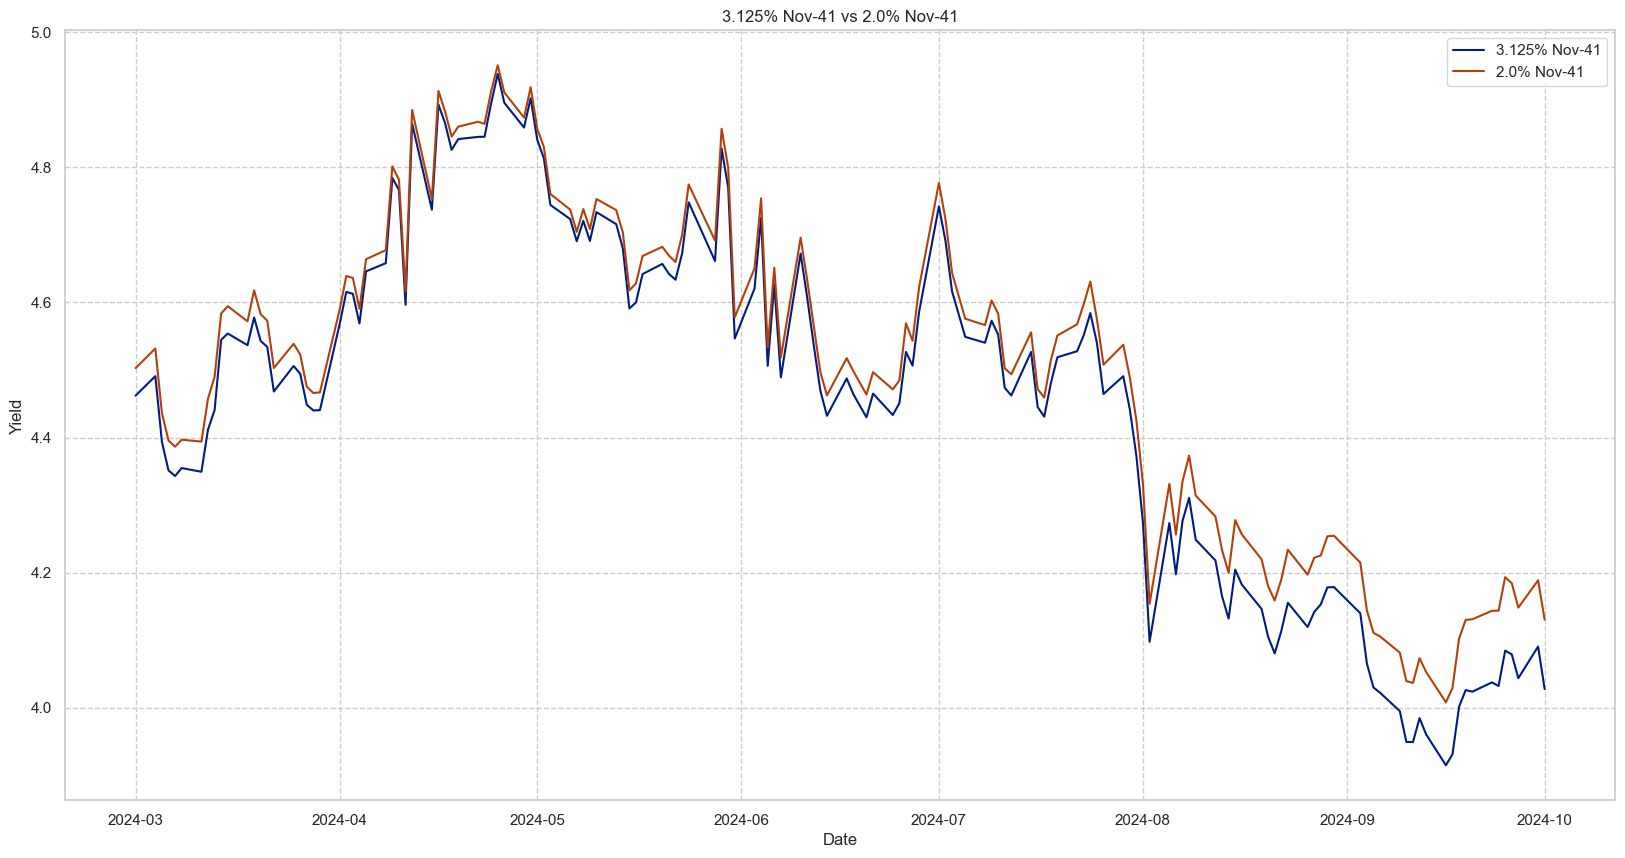

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df[label1], label=label1)
plt.plot(spread_df["Date"], spread_df[label2], label=label2)
plt.xlabel("Date")
plt.ylabel("Yield")
plt.title(f"{label1} vs {label2}")
plt.legend()
plt.grid(True)
plt.show()


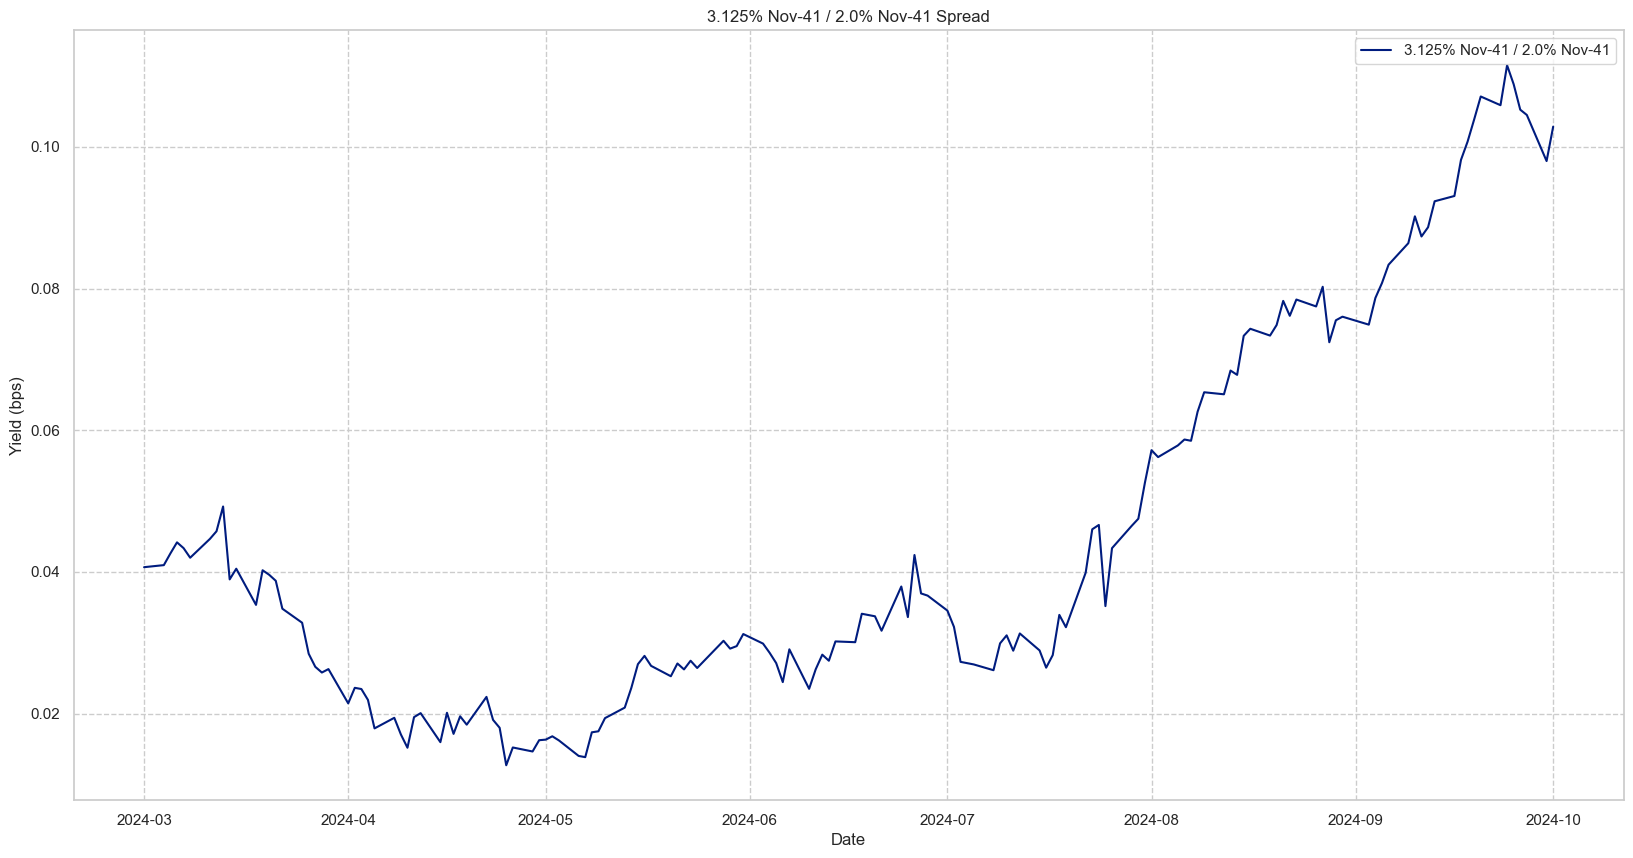

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df[f"{label1} / {label2}"], label=f"{label1} / {label2}")
plt.xlabel("Date")
plt.ylabel("Yield (bps)")
plt.title(f"{label1} / {label2} Spread")
plt.legend()
plt.grid(True)
plt.show()


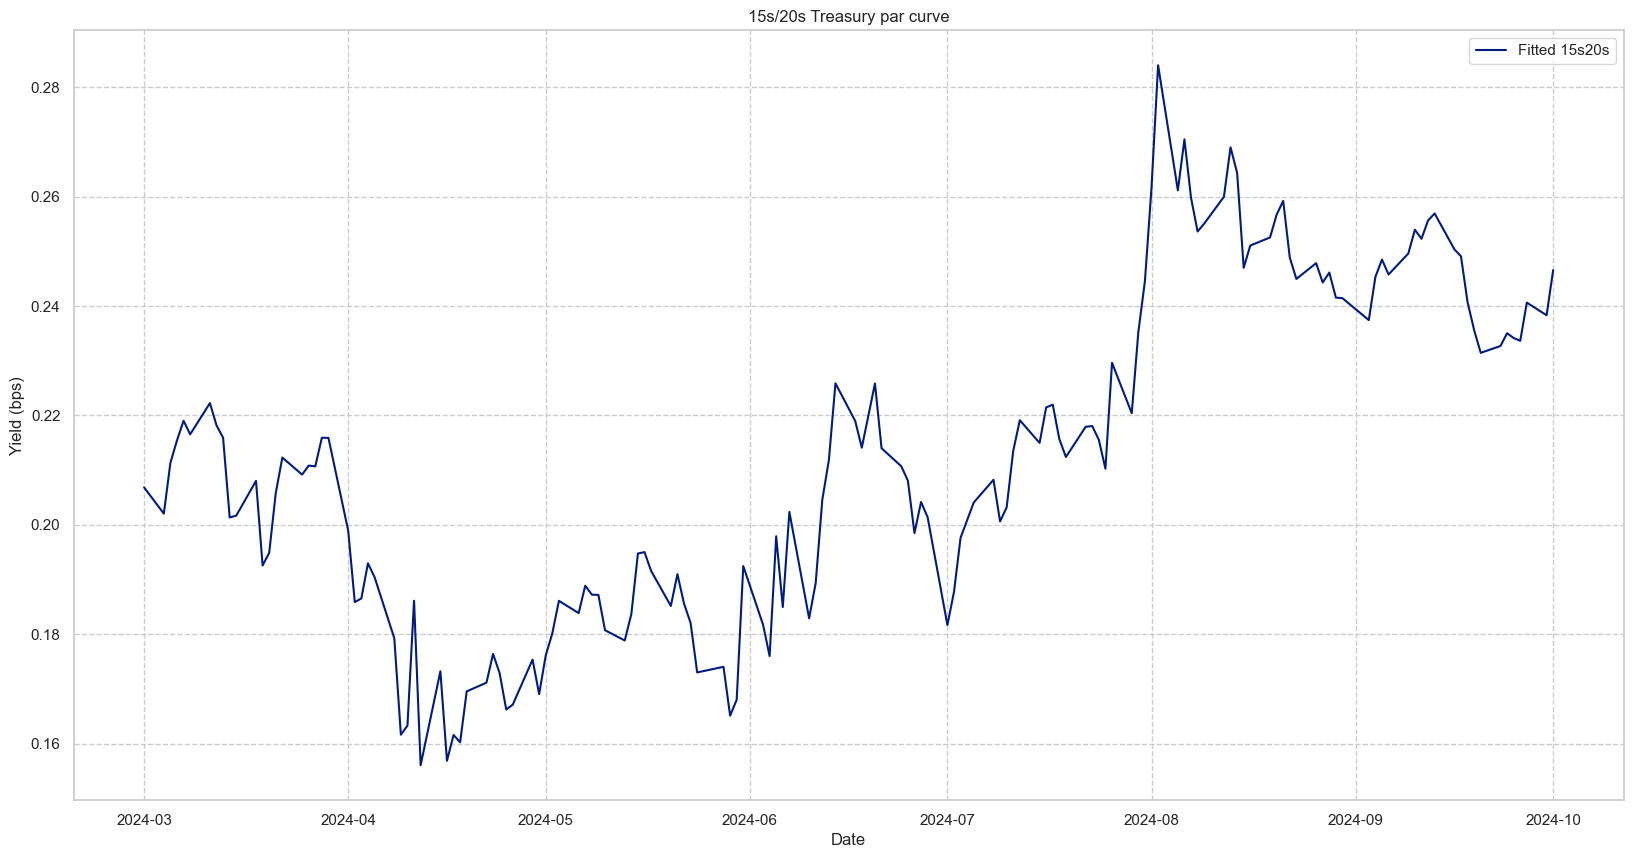

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(spread_df["Date"], spread_df["fitted_15s20s"], label="Fitted 15s20s")
plt.xlabel("Date")
plt.ylabel("Yield (bps)")
plt.title("15s/20s Treasury par curve")
plt.legend()
plt.grid(True)
plt.show()


                                 OLS Regression Results                                
Dep. Variable:     3.125% Nov-41 / 2.0% Nov-41   R-squared:                       0.643
Model:                                     OLS   Adj. R-squared:                  0.641
Method:                          Least Squares   F-statistic:                     264.7
Date:                         Thu, 03 Oct 2024   Prob (F-statistic):           1.08e-34
Time:                                 15:00:32   Log-Likelihood:                 405.18
No. Observations:                          149   AIC:                            -806.4
Df Residuals:                              147   BIC:                            -800.3
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

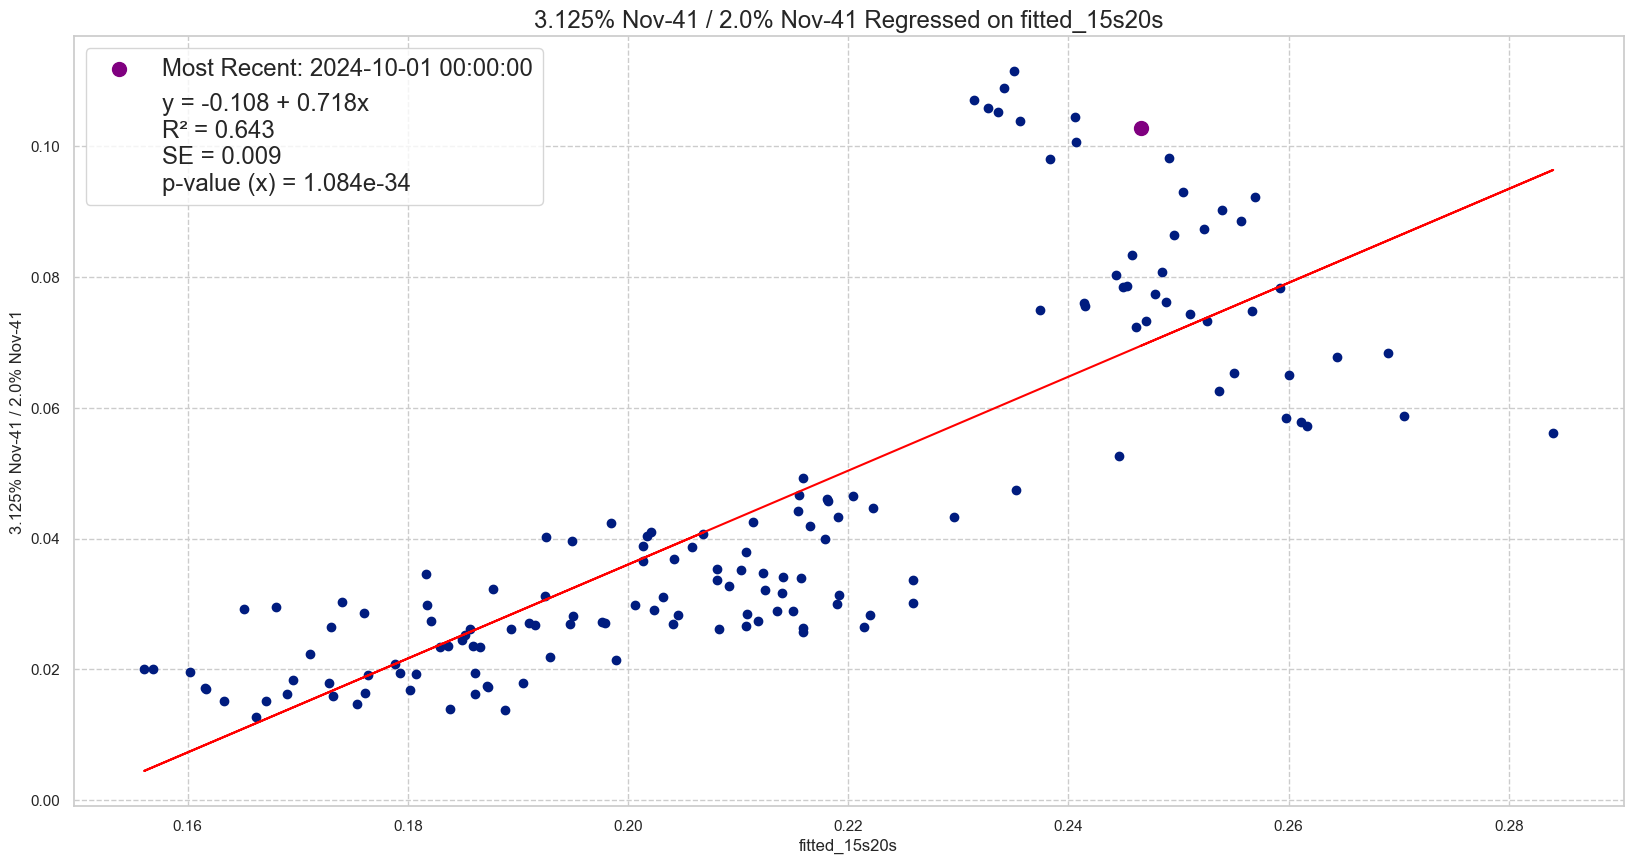

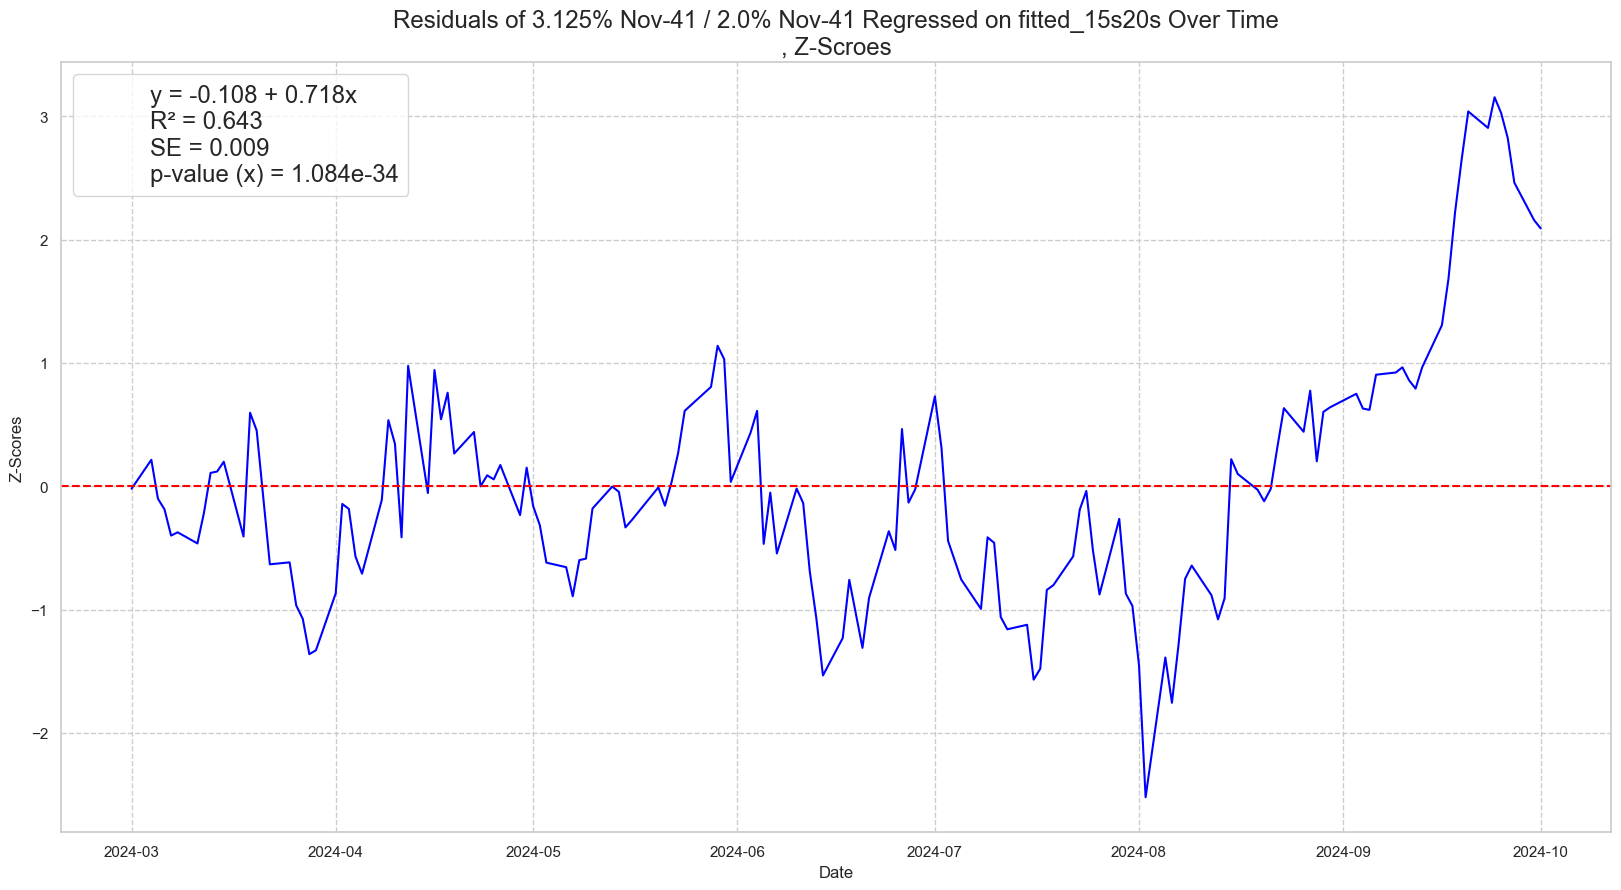

In [ ]:
r = run_basic_linear_regression_df(
    df=spread_df,
    x_col="fitted_15s20s",
    y_col=f"{label1} / {label2}",
)

plot_residuals_timeseries(df=spread_df, results=r, plot_zscores=True)
